# Video Search




## Packages
To run this program, you need the following packages
```
pytube
torch
opencv-python
ultralytics
```

which can be installed using `pip install -r requirements.txt`

In [1]:
import os
import shutil
from pytube import YouTube
import cv2
import numpy as np
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import Generator

import matplotlib.pyplot as plt

USE_SQL = True  

try:
    import psycopg2
except:
    USE_SQL = False

In [2]:
# @title Options

# @markdown Re-run object detecting
RE_RECOGNIZE = False  # @param {type: "boolean"}
# @markdown Re-train autoencoder
RE_TRAIN = False  # @param {type: "boolean"}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 1:  Video library

Download the videos using pytube library.

https://www.youtube.com/watch?v=wbWRWeVe1XE

https://www.youtube.com/watch?v=FlJoBhLnqko

https://www.youtube.com/watch?v=Y-bVwPRy_no

In [4]:
# Download the videos
VIDEO_URLS = ["https://www.youtube.com/watch?v=wbWRWeVe1XE", "https://www.youtube.com/watch?v=FlJoBhLnqko", "https://www.youtube.com/watch?v=Y-bVwPRy_no"]
VIDEO_NAMES = ["video1.mp4", "video2.mp4", "video3.mp4"]
data_path = os.path.join("..", "data", "videos")
video_info = pd.DataFrame({"video_url": VIDEO_URLS, "video_name": VIDEO_NAMES, "video_path": [os.path.join(data_path, name) for name in VIDEO_NAMES]})

VIDEOID_TO_PROCESS = [0, 1, 2]

def video_download(video_url, download_path, video_name):
    yt = YouTube(video_url)
    yt.streams.filter(progressive=True).order_by('resolution').desc().first().download(download_path, video_name)

if not os.path.exists(data_path):
    os.makedirs(data_path)
for _, row in video_info.iterrows():
    if not os.path.exists(row["video_path"]):
        video_download(row["video_url"], data_path, row["video_name"])

# Get the fps of the videos
fpses = []
for _, row in video_info.iterrows():
    cap = cv2.VideoCapture(row["video_path"])
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    fpses.append(fps)

video_info["fps"] = fpses


## Step 2: Video indexing pipeline

In this step you will build and train your models to extract embeddings for the frames of your videos and store the extracted information in a database such as postgres for indexing the videos.

### 2.1 Preprocess the video

Use opencv and ffmpeg implement the preprocessing steps as shown below:

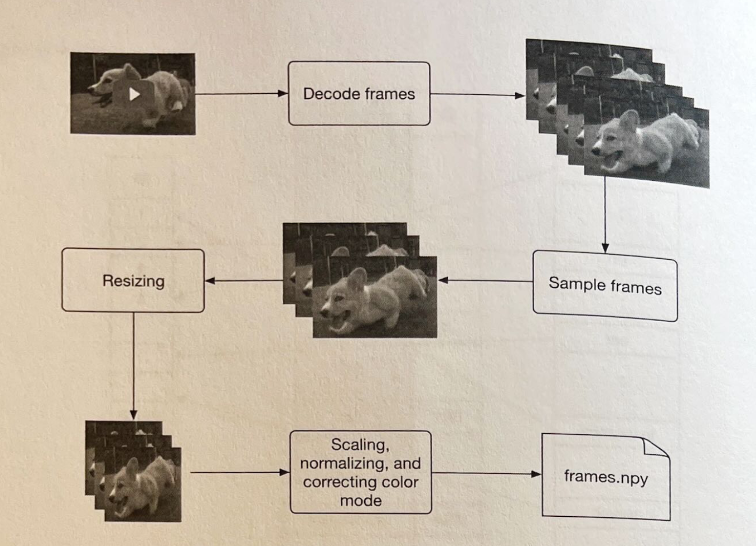



In [5]:
# use opencv to preprocess the videos

global SAMPLE_RATE 
SAMPLE_RATE = 1  # sample 1 frame per second
# RESIZE = (640, 640)  # resize the frames

def video_preprocess(video_index) -> np.ndarray:
    # open the video file
    cap = cv2.VideoCapture(video_info.iloc[video_index]["video_path"])
    
    # get the number of frames that should be sampled
    fps = video_info.iloc[video_index]["fps"]
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    global SAMPLE_RATE
    if(SAMPLE_RATE > fps):
        SAMPLE_RATE = fps
    num_frames = int(total_frames // (fps / SAMPLE_RATE)) + 1  # Add 1 to include the last frame
    
    # Create an empty array to store the preprocessed frames
    # frames = np.empty((num_frames, RESIZE[1], RESIZE[0], 3))
    frames = np.empty((num_frames, int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), 3))
    
    # Initialize the frame index
    frame_index = 0
    
    # Read frames from the video
    while cap.isOpened():
        # Read the next frame
        ret, frame = cap.read()
        
        # Break the loop if no more frames are available
        if not ret:
            break
        
        # Convert the frame to RGB color mode
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # # Resize the frame
        # frame = cv2.resize(frame, RESIZE)

        frames[frame_index] = frame
        frame_index += 1
        
        # Skip frames based on the sample rate
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index * (fps / SAMPLE_RATE) + 1)
    
    # Release the video capture object
    cap.release()
    
    return frames.astype(np.float32)

videos = {}
for i in VIDEOID_TO_PROCESS:
    videos[i] = video_preprocess(i)

### 2.2 Detecting objects

Use any of the pretrained object-detectors to detect objects belonging to MS COCO classes.
For each video, for each frame where a detection is found, compile and report the results in the following tabular structure :

`[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info]`

In [6]:
# Remove overlapped bounding boxes using non-maximum suppression
def iou_score(box1: np.ndarray, box2: np.ndarray) -> float:
    """
    Calculate the Intersection over Union (IoU) score of two bounding boxes.
    
    Parameters:
    box1 (np.ndarray): The first bounding box in the format (x1, y1, x2, y2).
    box2 (np.ndarray): The second bounding box in the format (x1, y1, x2, y2).
    
    Returns:
    float: The IoU score of the two bounding boxes.
    """
    # Calculate the intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Calculate the union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    
    # Calculate the IoU score
    iou = intersection_area / union_area
    return iou

def non_max_suppression(boxes, scores, threshold: float) -> list:
    """
    Non-maximum suppression to remove overlapping bounding boxes.

    Parameters:
    boxes (list): A list of np.ndarray bounding boxes in the format (x1, y1, x2, y2).
    scores (list): A list of floats scores for each bounding box.
    threshold (float): The IoU threshold to use for the suppression.

    Returns:
    list: A list of the indices of the bounding boxes to keep.
    """
    # Create a list to hold the indices to keep
    keep = []
    
    # Sort the bounding boxes by their scores
    sorted_indices = np.argsort(scores)[::-1]
    
    # Iterate through the bounding boxes
    while len(sorted_indices) > 0:
        # Get the index of the current bounding box
        current_index = sorted_indices[0]
        
        # Add the current index to the list of indices to keep
        keep.append(current_index)
        
        # Get the coordinates of the current bounding box
        current_box = boxes[current_index]
        
        # Calculate the IoU scores of the current bounding box with the others
        iou_scores = np.array([iou_score(current_box, box) for box in boxes[sorted_indices[1:]]])
        
        # Find the indices of the bounding boxes that have a high IoU with the current one
        overlapping_indices = (iou_scores > threshold)

        # Remove the indices of the current bounding box and the overlapping ones
        sorted_indices = sorted_indices[np.append([False], np.logical_not(overlapping_indices))]
        
    return keep

In [21]:
# Use yolov5 to detect the objects in the videos

result_dir = os.path.join("..", "data", "results")
csv_path = os.path.join(result_dir, "results.csv")
obj_img_dir = os.path.join("..", "data", "obj_imgs")

if not os.path.exists(result_dir):
    os.makedirs(result_dir)


result_df = None
if os.path.exists(csv_path) and not RE_RECOGNIZE:
    result_df = pd.read_csv(csv_path)
    # Convert the bbox info to np.ndarray
    result_df["bbox info"] = result_df["bbox info"].apply(lambda x: np.array([int(i) for i in x[1:-1].split()], dtype=int))
    print(result_df.head())

else:

    # Load the yolov5 model
    yolov5 = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)  # for PIL/cv2/np inputs and NMS

    all_results = []
    for video_id, video in videos.items():
        for i, frame in enumerate(video):
            results = yolov5(frame).pandas().xyxy[0]  # Detect the objects in the frame

            # Remove the overlapped bounding boxes using non-maximum suppression
            bboxs = results[["xmin", "ymin", "xmax", "ymax"]].values
            scores = results["confidence"].values
            keep = non_max_suppression(bboxs, scores, 0.5)
            results = results.iloc[keep]

            all_results.append({"vidid": video_id, "frameNum": i , "result": results})  # Save the results for the frame

    #      xmin    ymin    xmax   ymax  confidence  class    name
    # 0  749.50   43.50  1148.0  704.5    0.874023      0  person
    # 1  433.50  433.50   517.5  714.5    0.687988     27     tie
    # 2  114.75  195.75  1095.0  708.0    0.624512      0  person
    # 3  986.00  304.00  1028.0  420.0    0.286865     27     tie

    # Arrange the results in the structure of [vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info]
    temp = []

    for i, frame_result in enumerate(all_results):
        vidid = frame_result["vidid"]
        frameNum = frame_result["frameNum"]
        for _, row in frame_result["result"].iterrows():
            temp.append({
                "vidId": vidid,
                "frameNum": frameNum, 
                "timestamp": str(datetime.timedelta(seconds=(i * video_info.iloc[vidid]["fps"] / SAMPLE_RATE))), 
                "detectedObjId": row["class"],
                "detectedObjClass": row["name"], 
                "confidence": row["confidence"], 
                "bbox info": np.array((np.round(row["xmin"]).astype(int), 
                                    np.round(row["ymin"]).astype(int), 
                                    np.round(row["xmax"]).astype(int), 
                                    np.round(row["ymax"]).astype(int)))})

    result_df = pd.DataFrame(temp)
    

    # dump detected objects to file
    if os.path.exists(obj_img_dir):
        shutil.rmtree(obj_img_dir)      # remove former results
    os.mkdir(obj_img_dir)
    
    file_names = []
    file_name = "video{vidid:01d}_frame{frameNum:04d}_obj{obj_index:02d}.png"
    file_path = os.path.join(obj_img_dir, file_name)
    result_df["obj_index"] = result_df.groupby(["vidId", "frameNum"]).cumcount()
    for _, row in result_df.iterrows():
        vidid = row["vidId"]
        frameNum = row["frameNum"]
        img = videos[vidid][frameNum]
        obj_index = row["obj_index"]
        x1, y1, x2, y2 = row["bbox info"]
        img = img[y1:y2, x1:x2]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(file_path.format(vidid=(vidid + 1), frameNum=frameNum, obj_index=obj_index), img)
        file_names.append(file_name.format(vidid=(vidid + 1), frameNum=frameNum, obj_index=obj_index))
    result_df.drop(columns=["obj_index"], inplace=True)
    result_df["img name"] = file_names

    # Save the results to a csv file
    result_df.to_csv(csv_path, index=False)
    print(result_df.head())

Using cache found in C:\Users\Cactus/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-2-28 Python-3.11.8 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


   vidId  frameNum       timestamp  detectedObjId detectedObjClass  \
0      1         5  0:01:59.880121              0           person   
1      1         5  0:01:59.880121              0           person   
2      1         5  0:01:59.880121              0           person   
3      1         5  0:01:59.880121              0           person   
4      1         5  0:01:59.880121              0           person   

   confidence               bbox info                    img name  
0    0.893714      [6, 432, 332, 715]  video2_frame0005_obj00.png  
1    0.874454    [469, 531, 590, 717]  video2_frame0005_obj01.png  
2    0.825352    [698, 548, 850, 717]  video2_frame0005_obj02.png  
3    0.818226  [1189, 558, 1218, 629]  video2_frame0005_obj03.png  
4    0.786860    [831, 509, 929, 660]  video2_frame0005_obj04.png  


### 2.3 Embedding model

Develop a convolutional autoencoder such as [the one described here](https://blog.keras.io/building-autoencoders-in-keras.html) whose input will be all the objects detected in each frame (not the entire frame!), if any.
Note : You can downsample the frame rate of your original video to avoid long training/processing times. For a given input image, the autoencoder should output it's small vector embedding.

Train your autoencoder on the COCO dataset for classes which get detected in the given list of videos.

In [8]:
# Build the pipeline to extract bbox of the detected objects for further embedding extraction

class BboxDataset(Dataset):
    def __init__(self, result_df):
        self.result_df = result_df

    def __len__(self):
        return len(self.result_df)

    def __getitem__(self, idx):
        vid_id = self.result_df.iloc[idx]["vidId"] 
        frame_num = self.result_df.iloc[idx]["frameNum"]
        bbox = self.result_df.iloc[idx]["bbox info"]
        obj = videos[vid_id][frame_num][bbox[1]:bbox[3], bbox[0]:bbox[2], :]
        obj = cv2.resize(obj, (84, 84))
        obj = torch.from_numpy(obj).permute(2, 0, 1).float()

        return obj

# Create an instance of the BboxDataset
dataset = BboxDataset(result_df)


In [9]:
# Autoencoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding='same')   
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding='same')  
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same') 
        self.fc1 = nn.Linear(64 * 10 * 10, 64 * 5 * 5)
        self.fc2 = nn.Linear(64 * 5 * 5, 224)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))    # (3, 84, 84) -> (16, 84, 84)
        x = self.pool(x)                # (16, 84, 84) -> (16, 42, 42)
        x = self.relu(self.conv2(x))    # (16, 42, 42) -> (32, 42, 42)
        x = self.pool(x)                # (32, 21, 21) -> (32, 21, 21)
        x = self.relu(self.conv3(x))    # (32, 21, 21) -> (64, 21, 21)
        x = self.pool(x)                # (64, 21, 21) -> (64, 10, 10)
        x = x.reshape(-1, 64 * 10 * 10)   # (64, 10, 10) -> (64 * 10 * 10)
        x = self.relu(self.fc1(x))      # (64 * 10 * 10) -> (64 * 5 * 5)
        x = self.relu(self.fc2(x))       # (64 * 5 * 5) -> (224, )
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(224, 64 * 5 * 5)
        self.fc2 = nn.Linear(64 * 5 * 5, 64 * 10 * 10)
        self.conv1 = nn.Conv2d(64, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 16, 3, padding='same')
        self.conv3 = nn.Conv2d(16, 3, 3, padding='same')
        self.relu = nn.ReLU()
        self.upsamplev1 = nn.Upsample(size=(21, 21), mode='nearest')
        self.upsamplev2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        x = self.relu(self.fc1(x))       # (224, ) -> (64 * 5 * 5)
        x = self.relu(self.fc2(x))       # (64 * 5 * 5) -> (64 * 10 * 10)
        x = x.reshape(-1, 64, 10, 10)      # (4096, ) -> (64, 8, 8)
        x = self.upsamplev1(x)           # (64, 10, 10) -> (64, 21, 21)
        x = self.relu(self.conv1(x))      # (64, 21, 21) -> (32, 21, 21)
        x = self.upsamplev2(x)            # (32, 21, 21) -> (32, 42, 42)
        x = self.relu(self.conv2(x))      # (32, 42, 42) -> (16, 42, 42)
        x = self.upsamplev2(x)            # (16, 42, 42) -> (16, 84, 84)
        x = self.relu(self.conv3(x))      # (16, 84, 84) -> (3, 84, 84)

        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [16]:
model_dir = os.path.join("..", "data", "models")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_path = os.path.join(model_dir, "encoder.pth")

if os.path.exists(model_path) and not RE_TRAIN:
    # load the trained encoder
    encoder = Encoder()
    encoder.load_state_dict(torch.load(model_path, map_location=device))
    encoder.eval()
    encoder.to(device)
    print("Encoder loaded")

else:
    # train the autoencoder
    autoencoder = Autoencoder().to(device)
    lossFn = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
    batch_size = 32

    obj_data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(100):
        loss_num = 0
        for obj in obj_data_loader:
            obj = obj.to(device)
            optimizer.zero_grad()
            output = autoencoder(obj)
            loss = lossFn(output, obj)
            loss.backward()
            optimizer.step()
            loss_num = loss.item()
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss_num:.4f}")

    # Save the trained encoder
    torch.save(autoencoder.encoder.state_dict(), model_path)

    # get the trained encoder for video embedding
    encoder = autoencoder.encoder

Epoch 5, Loss: 3234.4868
Epoch 10, Loss: 4738.6924
Epoch 15, Loss: 3463.0635
Epoch 20, Loss: 1025.3662
Epoch 25, Loss: 1546.7816
Epoch 30, Loss: 1781.1036
Epoch 35, Loss: 1041.8789
Epoch 40, Loss: 1042.3660
Epoch 45, Loss: 953.4266
Epoch 50, Loss: 1089.4668
Epoch 55, Loss: 958.5755
Epoch 60, Loss: 1465.4615
Epoch 65, Loss: 768.1114
Epoch 70, Loss: 1070.5166
Epoch 75, Loss: 701.0819
Epoch 80, Loss: 450.3662
Epoch 85, Loss: 444.1031
Epoch 90, Loss: 299.4055
Epoch 95, Loss: 590.0204
Epoch 100, Loss: 528.9903


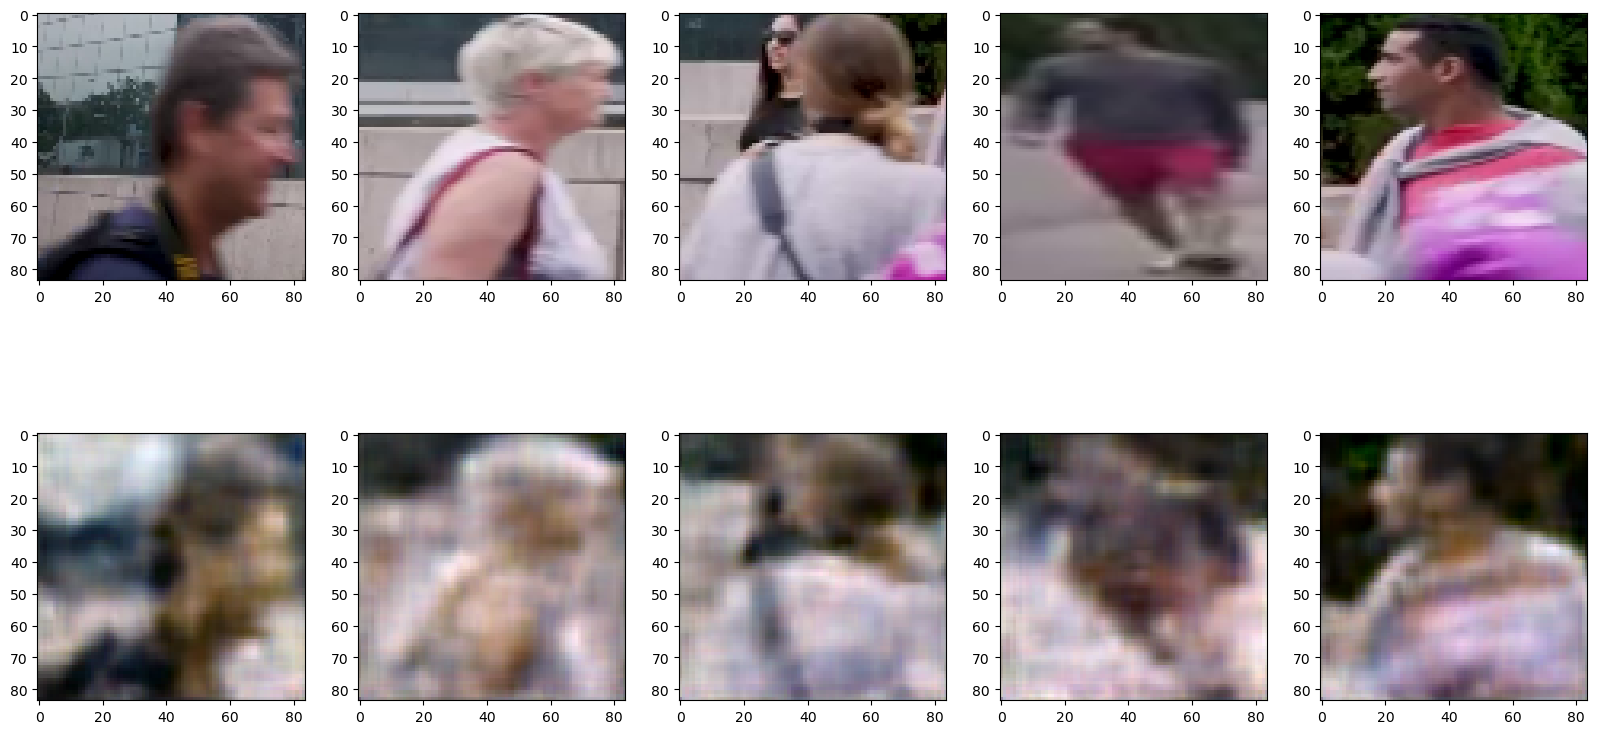

In [17]:
%matplotlib inline

# Compare the original and reconstructed objects
if "autoencoder" in locals():
    ax, fig = plt.subplots(2, 5, figsize=(20, 10))
    for i in range(5):
        obj = dataset[i]
        output = autoencoder(obj.unsqueeze(0).to(device)).cpu().detach().numpy().squeeze().transpose(1, 2, 0)
        output = output - np.min(output)
        output = output / np.max(output)
        obj = obj.numpy().transpose(1, 2, 0)
        obj = obj / 255
        fig[0, i].imshow(obj)
        fig[1, i].imshow(output)
    plt.show()



### Indexing the embeddings

Use `docker compose` to bring up two docker containers, your application container with the dev environment (you must have done this in Step 1) and a second container with postgres.

`docker pull postgres:latest`

Process all the detected object sub-images for each frame of each video to compile your final results in the following tabular structure:
[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info, vector<embedding of this object>, optional<sceneId from extra credit>]

Index the video images embedding vectors in the database. To do that in postgres (with the pgvector extension) you can use [this guide](https://dev.to/sfoteini/image-vector-similarity-search-with-azure-computer-vision-and-postgresql-12f7).

Demonstrate that you can search the database using image queries and post the screenshots of your search results that must include the first 10 similar images across the input videos.


In [12]:
def get_video_embedding(result_df) -> list:
    def get_obj_bbox() -> Generator[torch.Tensor, None, None]:
        for _, row in result_df.iterrows():
            vid_id = row["vidId"]
            frame_num = row["frameNum"]
            bbox = row["bbox info"]
            obj = videos[vid_id][frame_num][bbox[1]:bbox[3], bbox[0]:bbox[2], :]
            obj = cv2.resize(obj, (84, 84))
            obj = torch.from_numpy(obj).permute(2, 0, 1).float()
            yield obj

    embeddings = []
    with torch.no_grad():
        for obj in get_obj_bbox():
            obj = obj.unsqueeze(0).to(device)
            embedding = encoder(obj).cpu().numpy().flatten()
            embeddings.append(embedding)
    return embeddings

In [13]:
embedded_path = os.path.join(result_dir, "embedded.csv")

embedded_df = None
if os.path.exists(embedded_path):
    embedded_df = pd.read_csv(embedded_path)
    embedded_df["vector"] = embedded_df["vector"].apply(lambda x: np.array([float(i) for i in x[1:-1].split()], dtype=float))
    embedded_df["bbox info"] = embedded_df["bbox info"].apply(lambda x: np.array([int(i) for i in x[1:-1].split()], dtype=int))
    print(embedded_df.head())
else:
    embedded_df = result_df.copy()
    # put vector before img_path
    embedded_df.insert(7, "vector", get_video_embedding(result_df))
    embedded_df.to_csv(embedded_path, index=False)

In [14]:
if USE_SQL:

    # Configure postgresql connection
    conn = psycopg2.connect(
        host="db",
        database="postgres",
        user="postgres",
        password="postgres",
    )

    cur = conn.cursor()

    # Use pyvector extension
    cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
    conn.commit()

    # Drop the table if it exists
    cur.execute("DROP TABLE IF EXISTS video_embedded;")
    conn.commit()

    # Create the table
    cur.execute("""
        CREATE TABLE video_embedded (
            vidid INTEGER,
            frameNum INTEGER,
            timestamp TEXT,
            detectedObjId INTEGER,
            detectedObjClass TEXT,
            confidence REAL,
            bbox_info VECTOR(4),
            embedding VECTOR(224),
            img_name TEXT
        );""")

    # Insert the data
    for _, row in embedded_df.iterrows():
        vidid = row["vidId"]
        frameNum = row["frameNum"]
        timestamp = row["timestamp"]
        detectedObjId = row["detectedObjId"]
        detectedObjClass = row["detectedObjClass"]
        confidence = row["confidence"]
        bbox_info = row["bbox info"].tolist()
        embedding = row["vector"].tolist()
        img_name = row["img name"]
        cur.execute("INSERT INTO video_embedded VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s);", 
                    (vidid, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, embedding, img_name))

    conn.commit()
    
    cur.close()
    conn.close()

In [ ]:
!python "image_query.py"